In [1]:
# To remove the warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import all necessity liabries
import zipfile
from google.colab import drive
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim

In [3]:
# To Access the Google Drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# To Unzip the folder
link_folder = '/content/drive/MyDrive/alzheimer_dataset.zip'
zip_ref     = zipfile.ZipFile(link_folder, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
class FolderException(Exception):
    def __init__(self, message="A custom exception"):
        super().__init__(message)

DIRECTORY = '/content/alzheimer_dataset/dataset'
CATEGORIES = ['mild', 'moderate', 'no', 'very_mild']
CONFIRM = 0
VAL_DATA = []
TRAIN_DATA = []

for folder in os.listdir(DIRECTORY):
    FOLDER = os.path.join(DIRECTORY, folder)
    if os.path.isdir(FOLDER):
        CONFIRM = CONFIRM + 1

if CONFIRM == 2:
    for sub_folder in os.listdir(DIRECTORY):
        if sub_folder == 'test':
            print("\t" * 5,"{} folder is accessing".format(sub_folder).upper())
            print("\t" * 2,"_" * 80, '\n')
            FULL_PATH = os.path.join(DIRECTORY, sub_folder)
            for category in CATEGORIES:
                IMAGE_PATH = os.path.join(FULL_PATH, category)
                for image_filename in os.listdir(IMAGE_PATH):
                    IMAGE_PATH = os.path.join(FULL_PATH, category, image_filename)
                    if os.path.exists(IMAGE_PATH):
                        image_array = cv2.resize(cv2.imread(IMAGE_PATH),
                                                 dsize = (120, 120))
                        image_label = CATEGORIES.index(category)
                        VAL_DATA.append([image_array,
                                         image_label])
                    else:
                        print(f"Warning: Image file not found at path {IMAGE_PATH}")

                print("\t" * 5, "{} folder is completed.\n".format(category))

            print("\t" * 2,"_" * 80, '\n')

        if sub_folder == 'train':
          print("\t"*5,"{} folder is accessing".format(sub_folder).upper())
          print("\t" * 2, "_" * 80,'\n')
          FULL_PATH = os.path.join(DIRECTORY, sub_folder)
          for category in CATEGORIES:
              IMAGE_PATH = os.path.join(FULL_PATH, category)
              for image_filename in os.listdir(IMAGE_PATH):
                  IMAGE_PATH = os.path.join(FULL_PATH, category, image_filename)
                  if os.path.exists(IMAGE_PATH):
                      image_array = cv2.resize(cv2.imread(IMAGE_PATH),
                                               dsize = (120, 120))
                      image_label = CATEGORIES.index(category)
                      TRAIN_DATA.append([image_array,
                                         image_label])
                  else:
                      print(f"Warning: Image file not found at path {IMAGE_PATH}")

              print("\t" * 5,"{} folder is completed.\n".format(category))

else:
    raise FolderException('''Folder Format like:
  xyz.zip
    |
  dataset(This folder name should be kept)
    |__train
    |   |__very_mild(here all the images would be kept)
    |   |__no(here all the images would be kept)
    |   |__mild(here all the images would be kept)
    |   |__moderate(here all the images would be kept)
    |__test
      |__very_mild(here all the images would be kept)
      |__no(here all the images would be kept)
      |__mild(here all the images would be kept)
      |__moderate(here all the images would be kept)
  ''')

					 TEST FOLDER IS ACCESSING
		 ________________________________________________________________________________ 

					 mild folder is completed.

					 moderate folder is completed.

					 no folder is completed.

					 very_mild folder is completed.

		 ________________________________________________________________________________ 

					 TRAIN FOLDER IS ACCESSING
		 ________________________________________________________________________________ 

					 mild folder is completed.

					 moderate folder is completed.

					 no folder is completed.

					 very_mild folder is completed.



In [6]:
# Do shuffle Random
random.shuffle(TRAIN_DATA)
random.shuffle(VAL_DATA)

In [7]:
# Split the dataset into independent & dependent - TRAIN_DATA
X_train = []
y_train = []

for (independent, dependent) in TRAIN_DATA:
  X_train.append(independent)
  y_train.append(dependent)

In [8]:
# Split the dataset into independent & dependent - VAL_DATA
X_val = []
y_val = []

for (independent, dependent) in VAL_DATA:
  X_val.append(independent)
  y_val.append(dependent)

In [9]:
train = len(np.unique(np.array(y_train)))
test  = len(np.unique(np.array(y_val)))

assert train == 4 and test == 4
print("Total target class # {} ".format(4))

Total target class # 4 


In [9]:
# Do the normalization
X_train = np.array(X_train)
X_val   = np.array(X_val)
y_train = np.array(y_train)
y_val   = np.array(y_val)

X_train = X_train/255
X_val   = X_val/255

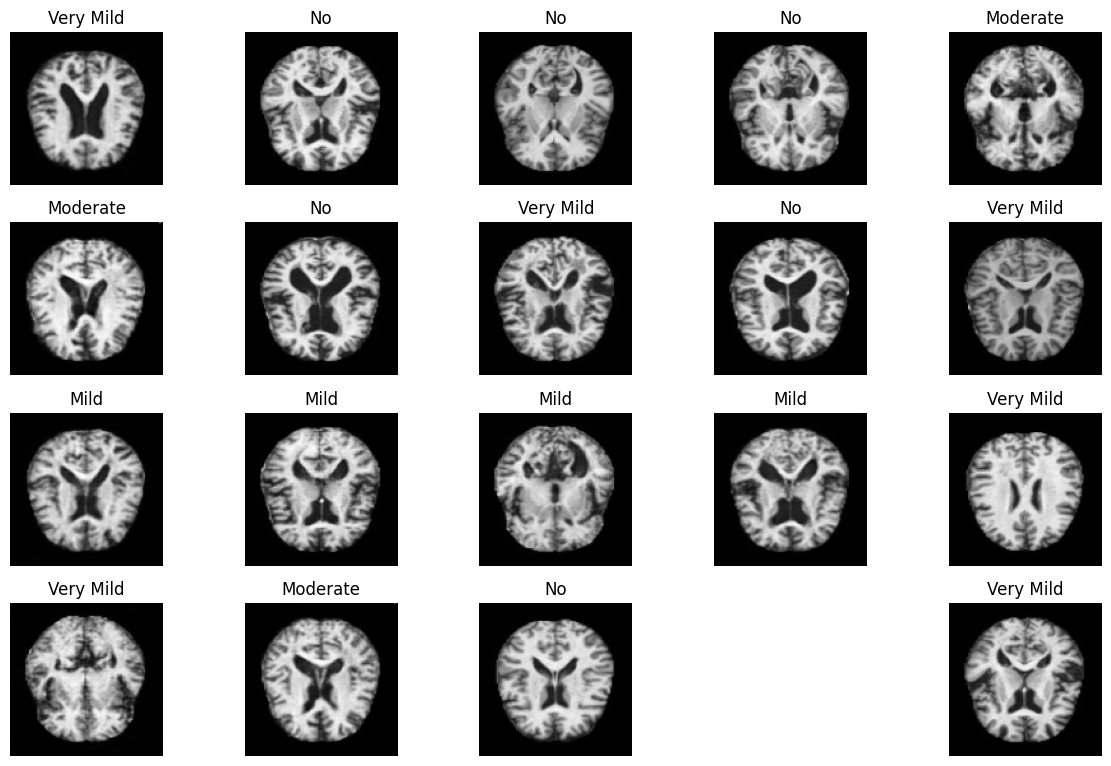

In [10]:
sample_data  = X_train[0:20]
sample_label = y_train[0:20]

plt.figure(figsize = (12, 8))

for index, image in enumerate(sample_data):
  plt.subplot(4, 5, index + 1)
  plt.imshow(image)
  plt.title('Mild' if sample_label[index] == 0\
             else 'Moderate' if sample_label[index] == 1\
             else 'No' if sample_label[index] == 2\
             else 'Very Mild'
            )
  plt.tight_layout()
  plt.axis("off")

plt.show()

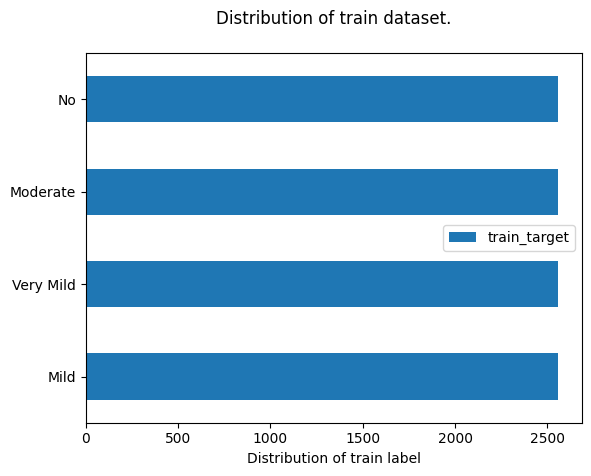

In [ ]:
import pandas as pd
plt.title("Distribution of Train dataset.\n".capitalize())
df = pd.DataFrame(y_train, columns = ['train_target'])
df.loc[:, 'train_target'].map({0: 'Mild', 1: 'Moderate', 2: 'No', 3: 'Very Mild'}).value_counts().plot(kind = 'barh')
plt.xlabel("Distribution of train label")
plt.legend()
plt.show()

In [10]:
# Data Loader
CHANNEL = 3
HEIGHT  = 120
WIDTH   = 120
BATCH_SIZE = 128

X_train = X_train.reshape(X_train.shape[0], CHANNEL, HEIGHT, WIDTH)
X_val   = X_val.reshape(X_val.shape[0], CHANNEL, HEIGHT, WIDTH)

X_train = torch.tensor(data = X_train, dtype = torch.float32)
X_val   = torch.tensor(data = X_train, dtype = torch.float32)

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_train, y_train, test_size = 0.30, random_state = 42)

print("X_train shape # {} ".format(X_train_data.shape), '\n')
print("y_train shape # {} ".format(y_train_data.shape), '\n')
print("X_test shape  # {} ".format(X_test_data.shape), '\n')
print("y_test shape  # {} ".format(y_test_data.shape), '\n')

TRAIN_LOADER = DataLoader(dataset = list(zip(X_train_data, y_train_data)),\
                          batch_size = BATCH_SIZE,\
                          shuffle = True)

TEST_LOADER  = DataLoader(dataset = list(zip(X_test_data, y_test_data)),\
                          batch_size = BATCH_SIZE,\
                          shuffle = True)


print("_"*60, '\n')
print("Batch size of Train # {} ".format(TRAIN_LOADER.batch_size), '\n')
print("Batch size of Test  # {} ".format(TEST_LOADER.batch_size), '\n')

print("_"*60, '\n')

# Extract the data and label
train_data, train_label = next(iter(TRAIN_LOADER))
test_data, test_label   = next(iter(TEST_LOADER))

print("Train data with single batch_size  # {} ".format(train_data.shape), '\n')
print("Train label with single batch_size # {} ".format(train_label.shape), '\n')
print("Test data with single batch_size  # {} ".format(test_data.shape), '\n')
print("Test label with single batch_size # {} ".format(test_label.shape))

X_train shape # torch.Size([7168, 3, 120, 120])  

y_train shape # (7168,)  

X_test shape  # torch.Size([3072, 3, 120, 120])  

y_test shape  # (3072,)  

____________________________________________________________ 

Batch size of Train # 128  

Batch size of Test  # 128  

____________________________________________________________ 

Train data with single batch_size  # torch.Size([128, 3, 120, 120])  

Train label with single batch_size # torch.Size([128])  

Test data with single batch_size  # torch.Size([128, 3, 120, 120])  

Test label with single batch_size # torch.Size([128]) 


In [11]:
class classifier(nn.Module):
  """
    A neural network classifier composed of convolutional and fully connected layers.

    Args:
        input_features (int): The number of input features, default is None.
        output_features (int): The number of output features, default is None.

    Attributes:
        LEFT_CONV (nn.Sequential): Left convolutional layers.
        MIDDLE_CONV (nn.Sequential): Middle convolutional layers.
        RIGHT_CONV (nn.Sequential): Right convolutional layers.
        FC_LAYER (nn.Sequential): Fully connected layers before branching into left, middle, and right.
        LEFT_FC (nn.Sequential): Left fully connected layers.
        MIDD_FC (nn.Sequential): Middle fully connected layers.
        RIGHT_FC (nn.Sequential): Right fully connected layers.

  """
  def __init__(self, input_features = None, output_features = None):
    super().__init__()

    self.LEFT_CONV   = self.left_conv_layer()
    self.MIDDLE_CONV = self.middle_conv_layer()
    self.RIGHT_CONV  = self.right_conv_layer()

    self.FC_LAYER = self.fully_connected_layer()
    self.LEFT_FC  = self.left_fc_layer()
    self.MIDD_FC  = self.middle_fc_layer()
    self.RIGHT_FC = self.right_fc_layer()

  def left_conv_layer(self):
    """
    Defines a sequence of convolutional and pooling layers in PyTorch.

    This sequence consists of three convolutional layers, each followed by a ReLU activation function
    and a max-pooling layer with 2x2 kernel size and stride 2, effectively reducing spatial dimensions.
    The convolutional layers have varying numbers of input and output channels, kernel sizes, and padding.

    - 1st Convolutional Layer:
        - Input channels: 3 (assumes RGB image)
        - Output channels: 32
        - Kernel size: 3x3
        - Padding: 1
    - 2nd Convolutional Layer:
        - Input channels: 32
        - Output channels: 16
        - Kernel size: 3x3
        - Padding: 1
    - 3rd Convolutional Layer:
        - Input channels: 16
        - Output channels: 8
        - Kernel size: 3x3
        - Padding: 1
    """
    return nn.Sequential(
        nn.Conv2d(in_channels  = 3,
                  out_channels = 32,
                  kernel_size  = (3, 3),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),

        nn.Conv2d(in_channels  = 32,
                  out_channels = 16,
                  kernel_size  = (3, 3),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),
        nn.Dropout(p = 0.5),

        nn.Conv2d(in_channels  = 16,
                  out_channels = 8,
                  kernel_size  = (3, 3),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),
        nn.Dropout(p = 0.3),
    )

  def middle_conv_layer(self):
    """
    Defines a sequence of convolutional and pooling layers in PyTorch.

    This sequence consists of three convolutional layers, each followed by a ReLU activation function
    and a max-pooling layer with 2x2 kernel size and stride 2, effectively reducing spatial dimensions.
    The convolutional layers have varying numbers of input and output channels, kernel sizes, and padding.

    - 1st Convolutional Layer:
        - Input channels: 3 (assumes RGB image)
        - Output channels: 32
        - Kernel size: 4x4
        - Padding: 1
    - 2nd Convolutional Layer:
        - Input channels: 32
        - Output channels: 16
        - Kernel size: 4x4
        - Padding: 1
    - 3rd Convolutional Layer:
        - Input channels: 16
        - Output channels: 8
        - Kernel size: 4x4
        - Padding: 1
    """
    return nn.Sequential(
        nn.Conv2d(in_channels  = 3,
                  out_channels = 32,
                  kernel_size  = (4, 4),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),

        nn.Conv2d(in_channels  = 32,
                  out_channels = 16,
                  kernel_size  = (4, 4),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),
        nn.Dropout(p = 0.4),

        nn.Conv2d(in_channels  = 16,
                  out_channels = 8,
                  kernel_size  = (4, 4),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2))
    )

  def right_conv_layer(self):
    """
    Defines a sequence of convolutional and pooling layers in PyTorch.

    This sequence consists of three convolutional layers, each followed by a ReLU activation function
    and a max-pooling layer with 2x2 kernel size and stride 2, effectively reducing spatial dimensions.
    The convolutional layers have varying numbers of input and output channels, kernel sizes, and padding.

    - 1st Convolutional Layer:
        - Input channels: 3 (assumes RGB image)
        - Output channels: 32
        - Kernel size: 5x5
        - Padding: 1
    - 2nd Convolutional Layer:
        - Input channels: 32
        - Output channels: 16
        - Kernel size: 5x5
        - Padding: 1
    - 3rd Convolutional Layer:
        - Input channels: 16
        - Output channels: 8
        - Kernel size: 5x5
        - Padding: 1
    """
    return nn.Sequential(
        nn.Conv2d(in_channels  = 3,
                  out_channels = 32,
                  kernel_size  = (5, 5),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),

        nn.Conv2d(in_channels  = 32,
                  out_channels = 16,
                  kernel_size  = (5, 5),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),
        nn.Dropout(p = 0.3),

        nn.Conv2d(in_channels  = 16,
                  out_channels = 8,
                  kernel_size  = (5, 5),
                  stride  = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2),
                     stride = (2, 2)),
        nn.Dropout(p = 0.4),
    )

  def fully_connected_layer(self):
    return nn.Sequential(
        nn.Linear(in_features  = 15 * 15 * 8 + 14 * 14 * 8 + 13 * 13 * 8,
                  out_features = 256),

        nn.LeakyReLU()
    )

  def left_fc_layer(self):
    """
    Defines a sequence of fully connected layers in PyTorch.

    This sequence consists of four fully connected (linear) layers, each followed by a ReLU activation function
    and, in some cases, a dropout layer with a specified dropout probability. The fully connected layers have
    different numbers of input and output features.

    - 1st Fully Connected Layer:
        - Input features: 256
        - Output features: 128
    - ReLU Activation Function
    - 2nd Fully Connected Layer:
        - Input features: 128
        - Output features: 64
    - ReLU Activation Function
    - Dropout Layer (p=0.5): Applies dropout with a probability of 0.5
    - 3rd Fully Connected Layer:
        - Input features: 64
        - Output features: 16
    - ReLU Activation Function
    - Dropout Layer (p=0.5): Applies dropout with a probability of 0.5
    - 4th Fully Connected Layer:
        - Input features: 16
        - Output features: 4
    - Softmax Activation Function: Used for multi-class classification

    Note: The final softmax layer is typically used for classification tasks to obtain class probabilities.
    """
    return nn.Sequential(
        nn.Linear(in_features  = 256,
                  out_features = 128),
        nn.ReLU(),

        nn.Linear(in_features  = 128,
                  out_features = 64),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(in_features  = 64,
                  out_features = 16),
        nn.ReLU(),
        nn.Dropout(p = 0.3),

        nn.Linear(in_features  = 16,
                  out_features = 4),
        nn.Softmax()
    )

  def middle_fc_layer(self):
    """
    Defines a sequence of fully connected layers in PyTorch.

    This sequence consists of four fully connected (linear) layers, each followed by a ReLU activation function
    and, in some cases, a dropout layer with a specified dropout probability. The fully connected layers have
    different numbers of input and output features.

    - 1st Fully Connected Layer:
        - Input features: 256
        - Output features: 64
    - ReLU Activation Function
    - 2nd Fully Connected Layer:
        - Input features: 64
        - Output features: 32
    - ReLU Activation Function
    - Dropout Layer (p=0.5): Applies dropout with a probability of 0.5
    - 3rd Fully Connected Layer:
        - Input features: 32
        - Output features: 4
    - Softmax Activation Function: Used for multi-class classification

    Note: The final softmax layer is typically used for classification tasks to obtain class probabilities.
    """
    return nn.Sequential(
        nn.Linear(in_features  = 256,
                  out_features = 64),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(in_features  = 64,
                  out_features = 32),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(in_features  = 32,
                  out_features = 4),
        nn.Softmax()
    )

  def right_fc_layer(self):
    """
    Defines a sequence of fully connected layers in PyTorch.

    This sequence consists of four fully connected (linear) layers, each followed by a ReLU activation function
    and, in some cases, a dropout layer with a specified dropout probability. The fully connected layers have
    different numbers of input and output features.

    - 1st Fully Connected Layer:
        - Input features: 256
        - Output features: 32
    - ReLU Activation Function
    - 2nd Fully Connected Layer:
        - Input features: 64
        - Output features: 16
    - ReLU Activation Function
    - Dropout Layer (p=0.5): Applies dropout with a probability of 0.5
    - 3rd Fully Connected Layer:
        - Input features: 16
        - Output features: 4
    - Softmax Activation Function: Used for multi-class classification

    Note: The final softmax layer is typically used for classification tasks to obtain class probabilities.
    """
    return nn.Sequential(
        nn.Linear(in_features  = 256,
                  out_features = 32),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(in_features  = 32,
                  out_features = 16),
        nn.ReLU(),
        nn.Dropout(p = 0.3),

        nn.Linear(in_features  = 16,
                  out_features = 4),
        nn.Softmax()
    )
  def forward(self, x):
    """
    Forward pass of the classifier neural network.

    This method defines the forward pass of the classifier neural network, which consists of the following steps:

    1. Applying the LEFT_CONV, MIDDLE_CONV, and RIGHT_CONV convolutional layers to the input tensor x to extract features.
    2. Reshaping the output of each convolutional branch to have a 1D representation.
    3. Concatenating the flattened outputs of the three branches along dimension 1 to combine features.
    4. Applying the FC_LAYER, a fully connected layer, to the concatenated feature representation.
    5. Branching into LEFT_FC, MIDDLE_FC, and RIGHT_FC fully connected layers for different tasks.
    6. Returning the output of each branch.

    Args:
        x (torch.Tensor): The input tensor to the network.

    Returns:
        tuple: A tuple containing the outputs of the LEFT_FC, MIDDLE_FC, and RIGHT_FC branches.

    Note:
        - LEFT_FC, MIDDLE_FC, and RIGHT_FC are typically used for different subtasks or classes.
        - The concatenation allows the network to capture joint information from the three convolutional branches.
    """
    LEFT   = self.LEFT_CONV(x)
    MIDDLE = self.MIDDLE_CONV(x)
    RIGHT  = self.RIGHT_CONV(x)

    LEFT   = LEFT.reshape(LEFT.shape[0], -1)
    MIDDLE = MIDDLE.reshape(MIDDLE.shape[0], -1)
    RIGHT  = RIGHT.reshape(LEFT.shape[0], -1)

    CONCAT = torch.cat((LEFT, MIDDLE, RIGHT), dim = 1)

    FC_LAYER = self.FC_LAYER(CONCAT)

    LEFT_FC   = self.LEFT_FC(FC_LAYER)
    MIDDLE_FC = self.MIDD_FC(FC_LAYER)
    RIGHT_FC  = self.RIGHT_FC(FC_LAYER)

    return LEFT_FC, MIDDLE_FC, RIGHT_FC

In [ ]:
model = classifier(input_features = 3, output_features = 4)

In [ ]:
print(model.parameters)

<bound method Module.parameters of classifier(
  (LEFT_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (MIDDLE_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, 

In [ ]:
m1, m2, m3 = model(torch.randn(64, 3, 120, 120))

In [ ]:
m1.shape

torch.Size([64, 4])

In [ ]:
m2.shape

torch.Size([64, 4])

In [ ]:
m3.shape

torch.Size([64, 4])

In [ ]:
TOTAL_PARAMS = 0
for layer_name, params in model.named_parameters():
  if params.requires_grad:
    print("Layer # {} & Trainable Parameters # {} ".format(layer_name, params.numel()),'')
    TOTAL_PARAMS+=params.numel()

print("_"*100, "\n")
print("Total Trainable Parameters # {} ".format(TOTAL_PARAMS).upper())

Layer # LEFT_CONV.0.weight & Trainable Parameters # 864  
Layer # LEFT_CONV.0.bias & Trainable Parameters # 32  
Layer # LEFT_CONV.3.weight & Trainable Parameters # 4608  
Layer # LEFT_CONV.3.bias & Trainable Parameters # 16  
Layer # LEFT_CONV.6.weight & Trainable Parameters # 1152  
Layer # LEFT_CONV.6.bias & Trainable Parameters # 8  
Layer # MIDDLE_CONV.0.weight & Trainable Parameters # 1536  
Layer # MIDDLE_CONV.0.bias & Trainable Parameters # 32  
Layer # MIDDLE_CONV.3.weight & Trainable Parameters # 8192  
Layer # MIDDLE_CONV.3.bias & Trainable Parameters # 16  
Layer # MIDDLE_CONV.6.weight & Trainable Parameters # 2048  
Layer # MIDDLE_CONV.6.bias & Trainable Parameters # 8  
Layer # RIGHT_CONV.0.weight & Trainable Parameters # 2400  
Layer # RIGHT_CONV.0.bias & Trainable Parameters # 32  
Layer # RIGHT_CONV.3.weight & Trainable Parameters # 12800  
Layer # RIGHT_CONV.3.bias & Trainable Parameters # 16  
Layer # RIGHT_CONV.6.weight & Trainable Parameters # 3200  
Layer # RIGHT_

In [12]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [13]:
classifier1 = classifier(input_features = 3, output_features = 4)

In [14]:
# loss function
loss_function1 = nn.CrossEntropyLoss()
loss_function2 = nn.CrossEntropyLoss()
loss_function3 = nn.CrossEntropyLoss()

LEARNING_RATE1 = 0.001
LEARNING_RATE2 = 0.001
LEARNING_RATE3 = 0.001

optimizer1 = optim.Adam(classifier1.parameters(), lr = LEARNING_RATE1)
optimizer2 = optim.Adam(classifier1.parameters(), lr = LEARNING_RATE2)
optimizer3 = optim.Adam(classifier1.parameters(), lr = LEARNING_RATE3)

In [17]:
from pandas._libs.lib import maybe_convert_objects
EPOCHS = 500
MODEL1_ACC = []
MODEL2_ACC = []
MODEL3_ACC = []

MODEL1_LOSS = []
MODEL2_LOSS = []
MODEL3_LOSS = []

for epoch in range(EPOCHS):
  model1_total_pred = []
  model2_total_pred = []
  model3_total_pred = []

  model1_actual_label = []
  model2_actual_label = []
  model3_actual_label = []

  model1_total_loss = []
  model2_total_loss = []
  model3_total_loss = []

  for (X_batch, y_batch) in TRAIN_LOADER:
    # Convert the X_batch and y_batch into cuda
    X_batch = X_batch.to(device)
    y_batch = y_batch.long()
    y_batch = y_batch.to(device)

    # Move the model to the same device
    classifier1.to(device)

    # Do the prediction
    model1_prediction, model2_prediction, model3_prediction = classifier1(X_batch)

    # Compute the loss function
    model1_loss = loss_function1(model1_prediction, y_batch)
    model2_loss = loss_function2(model2_prediction, y_batch)
    model3_loss = loss_function3(model3_prediction, y_batch)

    # Do the backward propagation

    optimizer1.zero_grad()
    model1_loss.backward(retain_graph = True)
    optimizer1.step()

    optimizer2.zero_grad()
    model2_loss.backward(retain_graph = True)
    optimizer2.step()

    optimizer3.zero_grad()
    model3_loss.backward(retain_graph = True)
    optimizer3.step()

    model1_predicted = torch.argmax(model1_prediction, dim = 1)
    model2_predicted = torch.argmax(model2_prediction, dim = 1)
    model3_predicted = torch.argmax(model3_prediction, dim = 1)

    # Compute the total predict
    model1_total_pred.extend(model1_predicted.detach().cpu().flatten().numpy())
    model2_total_pred.extend(model2_predicted.detach().cpu().flatten().numpy())
    model3_total_pred.extend(model3_predicted.detach().cpu().flatten().numpy())

    model1_actual_label.extend(y_batch.cpu().flatten().detach().numpy())
    model2_actual_label.extend(y_batch.cpu().flatten().detach().numpy())
    model3_actual_label.extend(y_batch.cpu().flatten().detach().numpy())

    # Compute the loss
    model1_total_loss.append(model1_loss.item())
    model2_total_loss.append(model2_loss.item())
    model3_total_loss.append(model3_loss.item())


  # Compute the accuracy
  model1_acc = accuracy_score(model1_actual_label, model1_total_pred)
  model2_acc = accuracy_score(model2_actual_label, model2_total_pred)
  model3_acc = accuracy_score(model3_actual_label, model3_total_pred)

  # Validation
  model1_val_total_pred = []
  model2_val_total_pred = []
  model3_val_total_pred = []

  val_actual_label = []

  model1_val_total_loss = []
  model2_val_total_loss = []
  model3_val_total_loss = []
  for (val_data, val_label) in TEST_LOADER:
    val_data  = val_data.to(device)
    val_label = val_label.long()
    val_label = val_label.to(device)

    # Do the prediction
    model1_prediction, model2_prediction, model3_prediction = classifier1(val_data)

    # Compute the loss function
    model1_loss = loss_function1(model1_prediction, val_label)
    model2_loss = loss_function2(model2_prediction, val_label)
    model3_loss = loss_function3(model3_prediction, val_label)


    model1_val_predicted = torch.argmax(model1_prediction, dim = 1)
    model2_val_predicted = torch.argmax(model2_prediction, dim = 1)
    model3_val_predicted = torch.argmax(model3_prediction, dim = 1)

    # Compute the total predict
    model1_val_total_pred.extend(model1_val_predicted.detach().cpu().flatten().numpy())
    model2_val_total_pred.extend(model2_val_predicted.detach().cpu().flatten().numpy())
    model3_val_total_pred.extend(model3_val_predicted.detach().cpu().flatten().numpy())

    val_actual_label.extend(val_label.cpu().flatten().detach().numpy())

    # Compute the loss
    model1_val_total_loss.append(model1_loss.item())
    model2_val_total_loss.append(model2_loss.item())
    model3_val_total_loss.append(model3_loss.item())

  # Compute the accuracy
  model1_val_acc = accuracy_score(val_actual_label, model1_val_total_pred)
  model2_val_acc = accuracy_score(val_actual_label, model2_val_total_pred)
  model3_val_acc = accuracy_score(val_actual_label, model3_val_total_pred)

  print(" Epochs - {}/{} ".format(epoch, EPOCHS))
  print("[================] m1_loss: {:.4f} - m1_acc: {:.4f} - "
      "m2_loss: {:.4f} - m2_acc: {:.4f} - "
      "m3_loss: {:.4f} - m3_acc: {:.4f} - "
      "val1_loss: {:.4f} - val1_acc: {:.4f} - "
      "val2_loss: {:.4f} - val2_acc: {:.4f} - "
      "val3_loss: {:.4f} - val3_acc: {:.4f}".format(
          np.array(model1_total_loss).mean(),
          model1_acc,
          np.array(model2_total_loss).mean(),
          model2_acc,
          np.array(model3_total_loss).mean(),
          model3_acc,
          np.array(model1_val_total_loss).mean(),
          model1_val_acc,
          np.array(model2_val_total_loss).mean(),
          model2_val_acc,
          np.array(model3_val_total_loss).mean(),
          model3_val_acc
      ))


 Epochs - 0/500 
[================] m1_loss: 1.3864 - m1_acc: 0.2584 - m2_loss: 1.3860 - m2_acc: 0.2487 - m3_loss: 1.3865 - m3_acc: 0.2531 - val1_loss: 1.3852 - val1_acc: 0.2529 - val2_loss: 1.3866 - val2_acc: 0.2565 - val3_loss: 1.3843 - val3_acc: 0.2562
 Epochs - 1/500 
[================] m1_loss: 1.3287 - m1_acc: 0.3562 - m2_loss: 1.3250 - m2_acc: 0.3679 - m3_loss: 1.3411 - m3_acc: 0.3262 - val1_loss: 1.1828 - val1_acc: 0.5456 - val2_loss: 1.1796 - val2_acc: 0.5501 - val3_loss: 1.2130 - val3_acc: 0.5059
 Epochs - 2/500 
[================] m1_loss: 1.1244 - m1_acc: 0.5982 - m2_loss: 1.1252 - m2_acc: 0.6021 - m3_loss: 1.1485 - m3_acc: 0.5707 - val1_loss: 1.0887 - val1_acc: 0.6387 - val2_loss: 1.0927 - val2_acc: 0.6377 - val3_loss: 1.1029 - val3_acc: 0.6289


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def model_loss_compute(model_prediction = None, loss_function = None):
  if model_prediction:
    pass
  else:
    raise "model is not defined.".title()

In [15]:
check_classifier = classifier(input_features = 3, output_features = 4)

In [17]:
class Trainer:
  """
    A class for training multiple models with shared parameters.

    Args:
        classifier (nn.Module, optional): The shared classifier model. Default is None.

    Attributes:
        model1_loss_function (nn.Module): Loss function for model 1.
        model2_loss_function (nn.Module): Loss function for model 2.
        model3_loss_function (nn.Module): Loss function for model 3.
        model1_lr (float): Learning rate for model 1.
        model2_lr (float): Learning rate for model 2.
        model3_lr (float): Learning rate for model 3.
        model1_optimizer (optim.Optimizer): Optimizer for model 1.
        model2_optimizer (optim.Optimizer): Optimizer for model 2.
        model3_optimizer (optim.Optimizer): Optimizer for model 3.
        MODEL1_ACCURACY (list): List to store accuracy values for model 1.
        MODEL2_ACCURACY (list): List to store accuracy values for model 2.
        MODEL3_ACCURACY (list): List to store accuracy values for model 3.
        MODEL1_TOTAL_LOSS (list): List to store total loss values for model 1.
        MODEL2_TOTAL_LOSS (list): List to store total loss values for model 2.
        MODEL3_TOTAL_LOSS (list): List to store total loss values for model 3.

    Raises:
        ValueError: If the `classifier` is not provided, an exception is raised with an error message.

  """
  def __init__(self, classifier = None, device = None):
    self.classifier = classifier
    self.device     = device

    self.model1_loss_function = nn.CrossEntropyLoss()
    self.model2_loss_function = nn.CrossEntropyLoss()
    self.model3_loss_function = nn.CrossEntropyLoss()

    if classifier:
      self.model1_lr = 0.001
      self.model2_lr = 0.001
      self.model3_lr = 0.001

      self.model1_optimizer = optim.Adam(params = self.classifier.parameters(), lr = self.model1_lr)
      self.model2_optimizer = optim.Adam(params = self.classifier.parameters(), lr = self.model2_lr)
      self.model3_optimizer = optim.Adam(params = self.classifier.parameters(), lr = self.model3_lr)
    else:
      raise "model is not defined".title()

    self.history = {'m1_train_loss': [],
                    'm2_train_loss': [],
                    'm3_train_loss': [],
                    'm1_train_acc' : [],
                    'm2_train_acc' : [],
                    'm3_train_acc' : [],
                    'm1_val_loss'  : [],
                    'm2_val_loss'  : [],
                    'm3_val_loss'  : [],
                    'm1_val_acc'   : [],
                    'm2_val_acc'   : [],
                    'm3_val_acc'   : []
                    }
    self.get_model = list()

  def _connect_GPU(self, independent_data = None, dependent_data = None):
    """
    Connects the provided classifier and data to a GPU device, and ensures dependent_data is of 'long' type.

    :param classifier: The classifier to be moved to the GPU device.
    :param independent_data: The independent data to be moved to the GPU device.
    :param dependent_data: The dependent data to be converted to 'long' type and moved to the GPU device.

    :return: A tuple containing the independent data and dependent data, both residing on the GPU device.
    """
    independent_data = independent_data.to(self.device)
    dependent_data   = dependent_data.long()
    dependent_data   = dependent_data.to(device)

    return independent_data, dependent_data

  def _l1_regularization(self, model = None, lambda_value = 0.01):
    """
    Compute L1 regularization for the model's parameters.

    :param model: The model for which L1 regularization is computed.
    :param lambda_value: The regularization strength (lambda value).

    :return: The L1 regularization term as a scalar.
    """
    return sum(torch.norm(parameter, 1) for parameter in model.parameters())

  def _l2_regularization(self, model = None, lambda_value = 0.01):
    """
    Compute L2 regularization for the model's parameters.

    :param model: The model for which L1 regularization is computed.
    :param lambda_value: The regularization strength (lambda value).

    :return: The L2 regularization term as a scalar.
    """
    return sum(torch.norm(parameter, 2) for parameter in model.parameters())

  def _do_back_propagation(self, optimizer = None, model_loss = None):
    """
    Perform backpropagation to update model parameters.

    :param optimizer: The optimizer used for updating model parameters.
    :param model_loss: The loss computed for the model.

    This function performs the following steps:
    1. Zeroes out the gradients in the optimizer.
    2. Backpropagates the model_loss to compute gradients.
    3. Updates the model parameters using the optimizer.

    """
    optimizer.zero_grad()
    model_loss.backward(retain_graph = True)
    optimizer.step()

  def _compute_predicted_label(self, model_prediction = None):
    """
    Compute predicted labels from the model's predictions.

    :param model_prediction: The model's output predictions.

    :return: The computed predicted labels as a NumPy array.
    """
    model_predicted = torch.argmax(model_prediction, dim = 1)
    model_predicted = model_predicted.cpu().detach().flatten().numpy()

    return model_predicted
  def _compute_actual_label(self, actual_label = None):
    """
    Extract the actual labels from a tensor and convert them to a NumPy array.

    :param actual_label: The tensor containing the actual labels.

    :return: The actual labels as a NumPy array.
    """
    return actual_label.cpu().detach().flatten().numpy()

  def _compute_model_loss(self, model = None, loss_function = None, actual_label = None):
    """
    Computes the loss of a model given the actual labels using a specified loss function.

    :param model: The model for which the loss is to be computed.
    :param loss_function: The loss function used to compute the loss.
    :param actual_label: The actual labels for comparison.

    :return: The computed loss value.
    """
    return loss_function(model, actual_label)

  def _model_accuracy(self, actual_label = None, predicted_label = None):
    """
    Compute the accuracy of a model's predictions by comparing them to the actual labels.

    :param actual_label: The actual labels.
    :param predicted_label: The predicted labels.

    :return: The accuracy score as a float.
    """
    return accuracy_score(actual_label, predicted_label)

  def _display(self, model1_train_loss = None,
                     model2_train_loss = None,
                     model3_train_loss = None,
                     model1_train_acc  = None,
                     model2_train_acc  = None,
                     model3_train_acc  = None,
                     model1_val_loss   = None,
                     model2_val_loss   = None,
                     model3_val_loss   = None,
                     model1_val_acc    = None,
                     model2_val_acc    = None,
                     model3_val_acc    = None,
                     running_epochs    = None,
                     total_epochs      = None):
    """
    Display training and validation metrics for multiple models during the training process.

    :param model1_train_loss: Training loss for model 1.
    :param model2_train_loss: Training loss for model 2.
    :param model3_train_loss: Training loss for model 3.
    :param model1_train_acc: Training accuracy for model 1.
    :param model2_train_acc: Training accuracy for model 2.
    :param model3_train_acc: Training accuracy for model 3.
    :param model1_val_loss: Validation loss for model 1.
    :param model2_val_loss: Validation loss for model 2.
    :param model3_val_loss: Validation loss for model 3.
    :param model1_val_acc: Validation accuracy for model 1.
    :param model2_val_acc: Validation accuracy for model 2.
    :param model3_val_acc: Validation accuracy for model 3.
    :param running_epochs: Current epoch number.
    :param total_epochs: Total number of epochs.

    This function displays training and validation metrics for multiple models in a specific format.
    """

    print("Epochs: {}/{} ".format(running_epochs + 1, total_epochs))

    print("[================] m1_loss: {:.4f} - m1_acc: {:.4f} - "
                              "m2_loss: {:.4f} - m2_acc: {:.4f} - "
                              "m3_loss: {:.4f} - m3_acc: {:.4f} - "
                              "val1_loss: {:.4f} - val1_acc: {:.4f} - "
                              "val2_loss: {:.4f} - val2_acc: {:.4f} - "
                              "val3_loss: {:.4f} - val3_acc: {:.4f}".format(
                              np.array(model1_train_loss).mean(),
                              model1_train_acc,
                              np.array(model2_train_loss).mean(),
                              model2_train_acc,
                              np.array(model3_train_loss).mean(),
                              model3_train_acc,
                              np.array(model1_val_loss).mean(),
                              model1_val_acc,
                              np.array(model2_val_loss).mean(),
                              model2_val_acc,
                              np.array(model3_val_loss).mean(),
                              model3_val_acc
                              ))

  def performance(self):
    """
    Plot training and validation loss and accuracy for three different models.
    """
    # Create a subplot with 2 rows and 3 columns
    fig, axis = plt.subplots(2, 3, figsize=(16, 6))

    # Define model names and colors
    model_names = ['Model 1', 'Model 2', 'Model 3']
    colors = ['b', 'g', 'r']

    for i in range(3):
        # Plot training and validation loss for each model
        axis[0][i].plot(self.history[f'm{i+1}_train_loss'], label=f'{model_names[i]} Train Loss', color=colors[i])
        axis[0][i].plot(self.history[f'm{i+1}_val_loss'], label=f'{model_names[i]} Validation Loss', linestyle='--', color=colors[i])
        axis[0][i].set_title(f'{model_names[i]} Loss')
        axis[0][i].legend()

        # Plot training and validation accuracy for each model
        axis[1][i].plot(self.history[f'm{i+1}_train_acc'], label=f'{model_names[i]} Train Accuracy', color=colors[i])
        axis[1][i].plot(self.history[f'm{i+1}_val_acc'], label=f'{model_names[i]} Validation Accuracy', linestyle='--', color=colors[i])
        axis[1][i].set_title(f'{model_names[i]} Accuracy')
        axis[1][i].legend()

    plt.tight_layout()
    plt.show()

  def train(self, train_loader = None, test_loader = None, epochs = None):

    TRAIN_LOADER = train_loader
    TEST_LOADER  = test_loader
    TOTAL_EPOCHS = epochs

    for epoch in range(TOTAL_EPOCHS):
      """
        Lists to store accuracy and loss for each model and each batch.
      """
      model1_train_pred = []
      model2_train_pred = []
      model3_train_pred = []

      model_actual_label= []

      model1_train_loss = []
      model2_train_loss = []
      model3_train_loss = []

      for (X_train_batch, y_train_batch) in TRAIN_LOADER:
        X_train_batch, y_train_batch = self._connect_GPU(independent_data = X_train_batch, dependent_data = y_train_batch)

        # Do the prediction - train dataset
        model1, model2, model3 = self.classifier(X_train_batch)

        # Compute the models loss
        model1_loss = self._compute_model_loss(model = model1, loss_function = self.model1_loss_function, actual_label = y_train_batch)
        model2_loss = self._compute_model_loss(model = model2, loss_function = self.model2_loss_function, actual_label = y_train_batch)
        model3_loss = self._compute_model_loss(model = model3, loss_function = self.model3_loss_function, actual_label = y_train_batch)

        # Do the backpropagation
        self._do_back_propagation(optimizer = self.model1_optimizer, model_loss = model1_loss)
        self._do_back_propagation(optimizer = self.model2_optimizer, model_loss = model2_loss)
        self._do_back_propagation(optimizer = self.model3_optimizer, model_loss = model3_loss)

        # Compute the predicted labels
        model1_predicted = self._compute_predicted_label(model_prediction = model1)
        model2_predicted = self._compute_predicted_label(model_prediction = model2)
        model3_predicted = self._compute_predicted_label(model_prediction = model3)

        # Compute the actual labels
        model_actual_label.extend(self._compute_actual_label(actual_label = y_train_batch))

        # Store all preds and loss into list
        model1_train_pred.extend(model1_predicted)
        model2_train_pred.extend(model2_predicted)
        model3_train_pred.extend(model3_predicted)

        model1_train_loss.append(model1_loss.item())
        model2_train_loss.append(model2_loss.item())
        model3_train_loss.append(model3_loss.item())

      # Compute the accuracy
      model1_accuracy = self._model_accuracy(actual_label = model_actual_label, predicted_label = model1_train_pred)
      model2_accuracy = self._model_accuracy(actual_label = model_actual_label, predicted_label = model2_train_pred)
      model3_accuracy = self._model_accuracy(actual_label = model_actual_label, predicted_label = model3_train_pred)

      # Store accuracy & loss into the history
      self.history['m1_train_loss'].append(np.array(model1_train_loss).mean())
      self.history['m2_train_loss'].append(np.array(model2_train_loss).mean())
      self.history['m3_train_loss'].append(np.array(model3_train_loss).mean())

      self.history['m1_train_acc'].append(model1_accuracy)
      self.history['m2_train_acc'].append(model2_accuracy)
      self.history['m3_train_acc'].append(model3_accuracy)

      model1_test_pred = []
      model2_test_pred = []
      model3_test_pred = []

      model_actual_label= []

      model1_test_loss = []
      model2_test_loss = []
      model3_test_loss = []

      for (X_test_batch, y_test_batch) in TEST_LOADER:
        X_test_batch, y_test_batch = self._connect_GPU(independent_data = X_test_batch, dependent_data   = y_test_batch)
        # Do the prediction - test dataset
        model1, model2, model3 = self.classifier(X_test_batch)

        # Compute the models loss
        model1_loss = self._compute_model_loss(model = model1, loss_function = self.model1_loss_function, actual_label = y_test_batch)
        model2_loss = self._compute_model_loss(model = model2, loss_function = self.model2_loss_function, actual_label = y_test_batch)
        model3_loss = self._compute_model_loss(model = model3, loss_function = self.model3_loss_function, actual_label = y_test_batch)

        # Compute the predicted labels
        model1_predicted = self._compute_predicted_label(model_prediction = model1)
        model2_predicted = self._compute_predicted_label(model_prediction = model2)
        model3_predicted = self._compute_predicted_label(model_prediction = model3)

        # Compute the actual labels
        model_actual_label.extend(self._compute_actual_label(actual_label = y_test_batch))

        # Store all preds and loss into list
        model1_test_pred.extend(model1_predicted)
        model2_test_pred.extend(model2_predicted)
        model3_test_pred.extend(model3_predicted)

        model1_test_loss.append(model1_loss.item())
        model2_test_loss.append(model2_loss.item())
        model3_test_loss.append(model3_loss.item())

      # Compute the accuracy
      model1_val_accuracy = self._model_accuracy(actual_label = model_actual_label, predicted_label = model1_test_pred)
      model2_val_accuracy = self._model_accuracy(actual_label = model_actual_label, predicted_label = model2_test_pred)
      model3_val_accuracy = self._model_accuracy(actual_label = model_actual_label, predicted_label = model3_test_pred)

      # Store accuracy & loss into the history
      self.history['m1_val_loss'].append(np.array(model1_test_loss).mean())
      self.history['m2_val_loss'].append(np.array(model2_test_loss).mean())
      self.history['m3_val_loss'].append(np.array(model3_test_loss).mean())

      self.history['m1_val_acc'].append(model1_val_accuracy)
      self.history['m2_val_acc'].append(model2_val_accuracy)
      self.history['m3_val_acc'].append(model3_val_accuracy)

      self._display(model1_train_loss = model1_train_loss,
                    model2_train_loss = model2_train_loss,
                    model3_train_loss = model3_train_loss,
                    model1_train_acc  = model1_accuracy,
                    model2_train_acc  = model2_accuracy,
                    model3_train_acc  = model3_accuracy,
                    model1_val_loss   = model1_test_loss,
                    model2_val_loss   = model2_test_loss,
                    model3_val_loss   = model3_test_loss,
                    model1_val_acc    = model1_val_accuracy,
                    model2_val_acc    = model2_val_accuracy,
                    model3_val_acc    = model3_val_accuracy,
                    running_epochs    = epoch,
                    total_epochs      = TOTAL_EPOCHS)

    self.get_model.append(self.classifier)


In [18]:
if __name__ == "__main__":
  trainer = Trainer(classifier = check_classifier.to(device), device = device)
  trainer.train(train_loader = TRAIN_LOADER,
                test_loader = TEST_LOADER,
                epochs = 50)

Epochs: 1/50 
[================] m1_loss: 1.3707 - m1_acc: 0.2739 - m2_loss: 1.3708 - m2_acc: 0.2764 - m3_loss: 1.3717 - m3_acc: 0.2818 - val1_loss: 1.2376 - val1_acc: 0.4720 - val2_loss: 1.2575 - val2_acc: 0.4515 - val3_loss: 1.2730 - val3_acc: 0.4456
Epochs: 2/50 
[================] m1_loss: 1.1627 - m1_acc: 0.5565 - m2_loss: 1.1626 - m2_acc: 0.5593 - m3_loss: 1.1887 - m3_acc: 0.5333 - val1_loss: 1.1337 - val1_acc: 0.5983 - val2_loss: 1.1208 - val2_acc: 0.6051 - val3_loss: 1.1429 - val3_acc: 0.5758
Epochs: 3/50 
[================] m1_loss: 1.0962 - m1_acc: 0.6353 - m2_loss: 1.0964 - m2_acc: 0.6331 - m3_loss: 1.1138 - m3_acc: 0.6106 - val1_loss: 1.0799 - val1_acc: 0.6510 - val2_loss: 1.0773 - val2_acc: 0.6514 - val3_loss: 1.1086 - val3_acc: 0.6279
Epochs: 4/50 
[================] m1_loss: 1.0360 - m1_acc: 0.7012 - m2_loss: 1.0314 - m2_acc: 0.7037 - m3_loss: 1.0627 - m3_acc: 0.6663 - val1_loss: 0.9956 - val1_acc: 0.7493 - val2_loss: 1.0030 - val2_acc: 0.7406 - val3_loss: 1.0334 - val3_

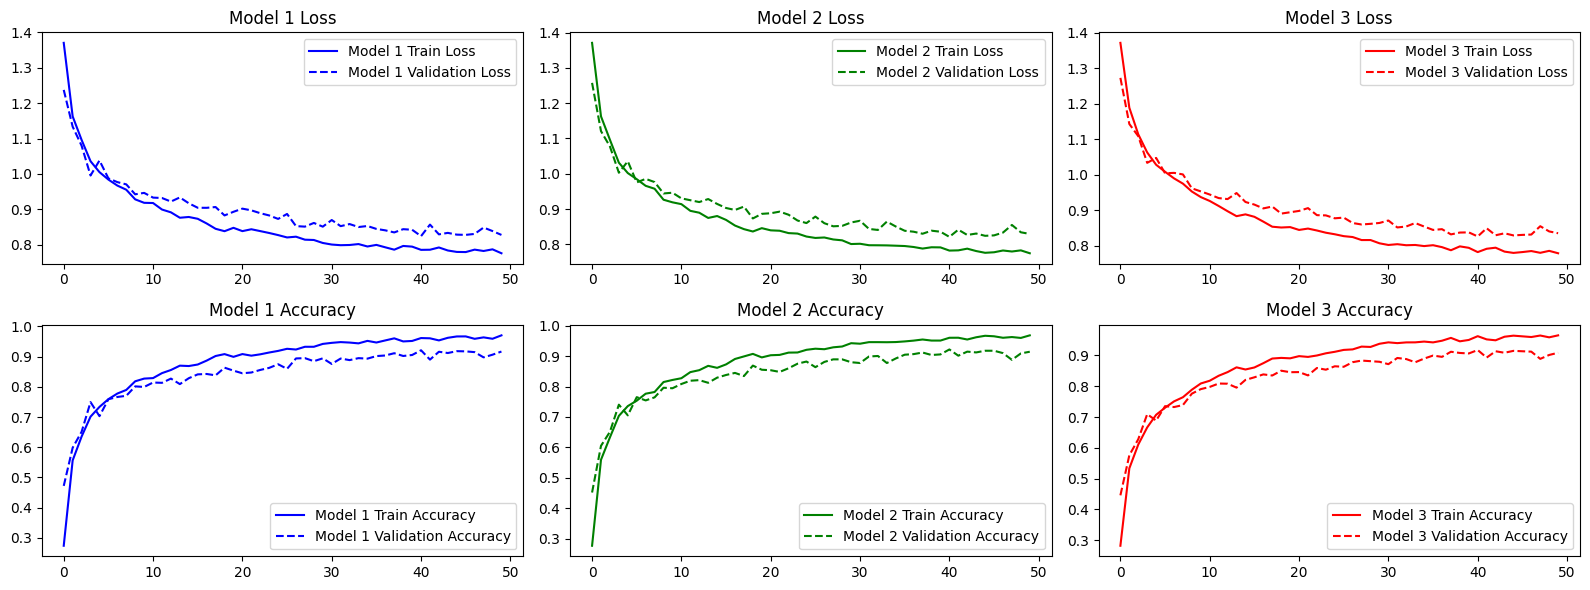

In [19]:
trainer.performance()

In [27]:
model = trainer.classifier

In [28]:
model

classifier(
  (LEFT_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.3, inplace=False)
  )
  (MIDDLE_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(ke

In [ ]:
trainer.history

{'m1_train_loss': [1.3867061191371508],
 'm2_train_loss': [1.386387278991086],
 'm3_train_loss': [1.3867042745862688],
 'm1_train_acc': [0.2544642857142857],
 'm2_train_acc': [0.25460379464285715],
 'm3_train_acc': [0.2525111607142857],
 'm1_val_loss': [1.3878141318758328],
 'm2_val_loss': [1.3859008600314457],
 'm3_val_loss': [1.3862443740169208],
 'm1_val_acc': [0.236328125],
 'm2_val_acc': [0.2587890625],
 'm3_val_acc': [0.2532552083333333]}

In [ ]:
# a = {'m1_train_loss': [1.3867061191371508],
#  'm2_train_loss': [1.386387278991086],
#  'm3_train_loss': [1.3867042745862688],
#  'm1_train_acc': [0.2544642857142857],
#  'm2_train_acc': [0.25460379464285715],
#  'm3_train_acc': [0.2525111607142857],
#  'm1_val_loss': [1.3878141318758328],
#  'm2_val_loss': [1.3859008600314457],
#  'm3_val_loss': [1.3862443740169208],
#  'm1_val_acc': [0.236328125],
#  'm2_val_acc': [0.2587890625],
#  'm3_val_acc': [0.2532552083333333]}

In [168]:
from collections import Counter
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

def _compute_majority_voting(predicted_label=None):
    """
    Compute majority voting for a list of predictions from three models.

    Args:
        predicted_label (list): A list of predictions from three models.

    Returns:
        list: A list of majority voting predictions.
    """
    voting_predict_labels = []

    for model1_pred, model2_pred, model3_pred in predicted_label:
        majority_voting = [model1_pred, model2_pred, model3_pred]

        majority_count = Counter(majority_voting)
        most_common_value = max(majority_count, key=majority_count.get)
        voting_predict_labels.append(most_common_value)

    return voting_predict_labels

def _compute_performance(model=None, dataloader=None):
    """
    Compute the performance of a model on a given data loader.

    Args:
        model: The model to evaluate.
        dataloader: DataLoader for the dataset.

    Returns:
        tuple: A tuple containing actual labels and predicted labels.
    """
    predict_labels = []
    actual_labels = []

    for (X_batch, y_batch) in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.long()
        y_batch = y_batch.to(device)

        model1_prediction, model2_prediction, model3_prediction = model(X_batch)

        model1_prediction = torch.argmax(model1_prediction, dim=1)
        model2_prediction = torch.argmax(model2_prediction, dim=1)
        model3_prediction = torch.argmax(model3_prediction, dim=1)

        model1_prediction = model1_prediction.cpu().detach().flatten().numpy()
        model2_prediction = model2_prediction.cpu().detach().flatten().numpy()
        model3_prediction = model3_prediction.cpu().detach().flatten().numpy()

        majority_voting = _compute_majority_voting(predicted_label=zip(model1_prediction, model2_prediction, model3_prediction))

        predict_labels.extend(majority_voting)
        actual_labels.extend(y_batch.cpu().detach().flatten().numpy())

    return actual_labels, predict_labels

def _show_classification_report(actual_labels=None, predict_labels=None):
    """
    Show the classification report based on actual and predicted labels.

    Args:
        actual_labels: Actual ground truth labels.
        predict_labels: Predicted labels.
    """
    print(classification_report(actual_labels, predict_labels))

def _confusion_matrix(actual_labels=None, predict_labels=None):
    """
    Display a confusion matrix based on actual and predicted labels.

    Args:
        actual_labels: Actual ground truth labels.
        predict_labels: Predicted labels.
    """
    sns.heatmap(confusion_matrix(actual_labels, predict_labels), annot=True, fmt=".1f")
    plt.show()

def model_performance(model=None, train_loader=None, test_loader=None, device=None):
    """
    Compute and display the performance metrics of a model on both training and testing datasets.

    Args:
        model: The model to evaluate.
        train_loader: DataLoader for the training dataset.
        test_loader: DataLoader for the testing dataset.
        device: The device (e.g., CPU or GPU) to use for evaluation.
    """
    actual_train_labels, predict_train_labels = _compute_performance(model=model, dataloader=train_loader)

    print("Evaluation of Train Dataset with {} records.".format(len(actual_train_labels)), '\n')

    print("ACCURACY  # {} ".format(accuracy_score(actual_train_labels, predict_train_labels)))
    print("PRECISION # {} ".format(recall_score(actual_train_labels, predict_train_labels, average='macro')))
    print("RECALL    # {} ".format(precision_score(actual_train_labels, predict_train_labels, average='macro')))
    print("F1_SCORE  # {} ".format(f1_score(actual_train_labels, predict_train_labels, average='macro')))

    print("_" * 50, "\n")

    actual_train_labels, predict_train_labels = _compute_performance(model=model, dataloader=test_loader)

    print("Ëvaluation of Test Dataset  {} records.".format(len(actual_train_labels)), '\n')

    print("ACCURACY  # {} ".format(accuracy_score(actual_train_labels, predict_train_labels)))
    print("PRECISION # {} ".format(recall_score(actual_train_labels, predict_train_labels, average='macro')))
    print("RECALL    # {} ".format(precision_score(actual_train_labels, predict_train_labels, average='macro')))
    print("F1_SCORE  # {} ".format(f1_score(actual_train_labels, predict_train_labels, average='macro')))

    print("_" * 50, "\n")

    print("Classification report for test dataset\n")
    _show_classification_report(actual_labels=actual_train_labels, predict_labels=predict_train_labels)

    print("Confusion matrix for test dataset\n")
    _confusion_matrix(actual_labels=actual_train_labels, predict_labels=predict_train_labels)

Evaluation of Train Dataset with 7168 records. 

ACCURACY  # 0.9693080357142857 
PRECISION # 0.9692595704351776 
RECALL    # 0.9692648726787266 
F1_SCORE  # 0.9692422863237884 
__________________________________________________ 

Ëvaluation of Test Dataset  3072 records. 

ACCURACY  # 0.9173177083333334 
PRECISION # 0.9175725547091511 
RECALL    # 0.9177444330650983 
F1_SCORE  # 0.9174764135566084 
__________________________________________________ 

Classification report for test dataset

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       787
           1       1.00      1.00      1.00       749
           2       0.89      0.85      0.87       766
           3       0.84      0.87      0.85       770

    accuracy                           0.92      3072
   macro avg       0.92      0.92      0.92      3072
weighted avg       0.92      0.92      0.92      3072

Confusion matrix for test dataset



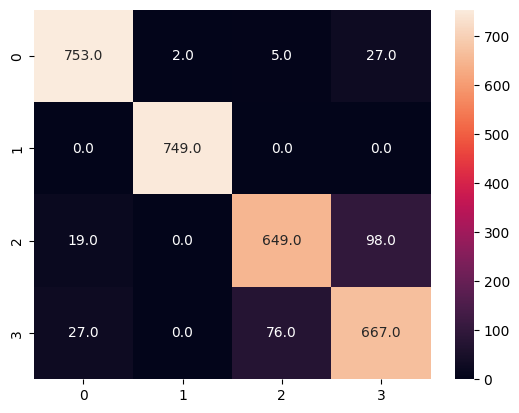

In [169]:
if __name__ == "__main__":
  model_performance(model = model, train_loader = TRAIN_LOADER, test_loader = TEST_LOADER)

In [95]:
a = [1, 0,2]
b = [0, 0, 2]
c = [1, 1, 7]
for a, b, c in list(zip(a, b, c)):
  print(a)

1
0
2


In [88]:
a = [1, 0,2]
b = [0, 0, 2]
c = [1, 1, 7]

from collections import Counter

for a, b, c in zip(a, b, c):
  majority_voting = []
  majority_voting.extend([a, b, c])
  print(Counter(majority_voting))
  print(list(dict(sorted(Counter(majority_voting).items(), key = lambda x: x[1], reverse=True)).keys())[0])

Counter({1: 2, 0: 1})
1
Counter({0: 2, 1: 1})
0
Counter({2: 2, 7: 1})
2


In [ ]:
torch.randn(64, 8, 13, 13).reshape(torch.randn(64, 8, 13, 13).shape[0], -1).shape

torch.Size([64, 1352])

#Check

In [1]:
# Import all necessity liabries
import zipfile
from google.colab import drive
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim

In [2]:
!pip install -t . git+https://github.com/atikul-islam-sajib/alzheimer_classifier_pypi.git --upgrade

  Cloning https://github.com/atikul-islam-sajib/alzheimer_classifier_pypi.git to /tmp/pip-req-build-2ijvp1s4
  Running command git clone --filter=blob:none --quiet https://github.com/atikul-islam-sajib/alzheimer_classifier_pypi.git /tmp/pip-req-build-2ijvp1s4
  Resolved https://github.com/atikul-islam-sajib/alzheimer_classifier_pypi.git to commit 023744053e39b6cd1299a78f4a33773892cdcb04
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 119.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 16.2 MB/s eta 0:00:00
  

In [3]:
!pip show alzheimer_classifier

In [4]:
import alzheimer_classifier

In [5]:
from alzheimer_classifier.dataset import load_data

In [6]:
loader = load_data(filename = '/content/alzheimer_dataset.zip', extract_to = '/content/')

train_loader, test_loader = loader.dataloader()

Unzipping is in progress. It will take some time, so please be patient.

					 TEST FOLDER IS ACCESSING
		 ________________________________________________________________________________ 

					 mild folder is completed.

					 moderate folder is completed.

					 no folder is completed.

					 very_mild folder is completed.

		 ________________________________________________________________________________ 

					 TRAIN FOLDER IS ACCESSING
		 ________________________________________________________________________________ 

					 mild folder is completed.

					 moderate folder is completed.

					 no folder is completed.

					 very_mild folder is completed.

		 ________________________________________________________________________________ 

					 DETAILS OF DATASET
		 ________________________________________________________________________________ 

					 Length of train data # 10240  

					 Length of validation data # 1279  

					 Total number of target class # 4  

					 X_t

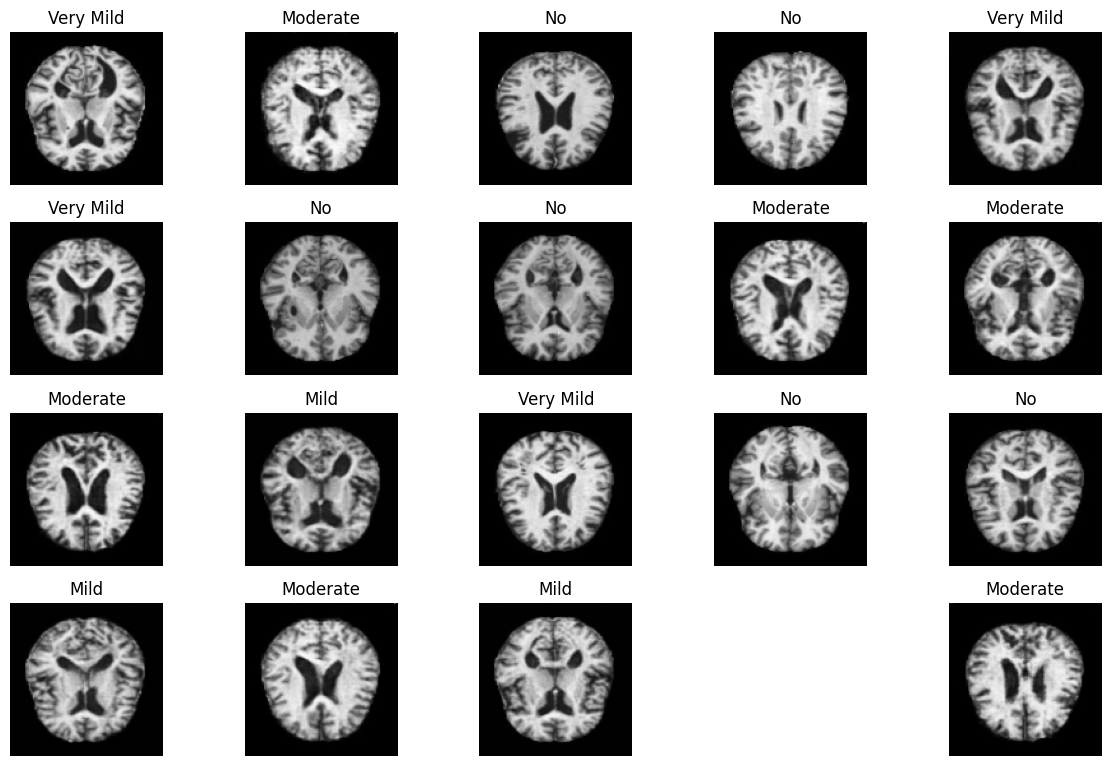

In [7]:
loader.show_plot()

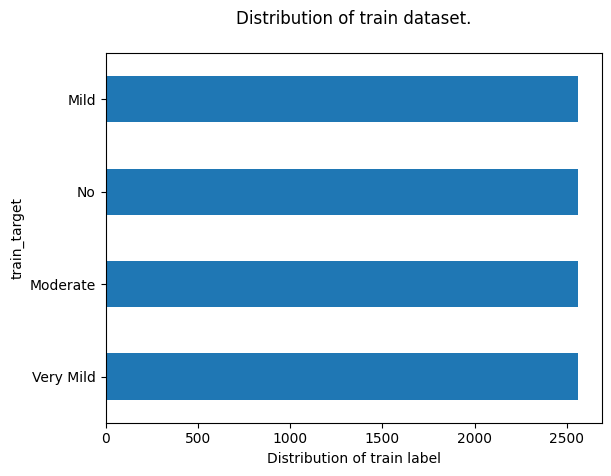

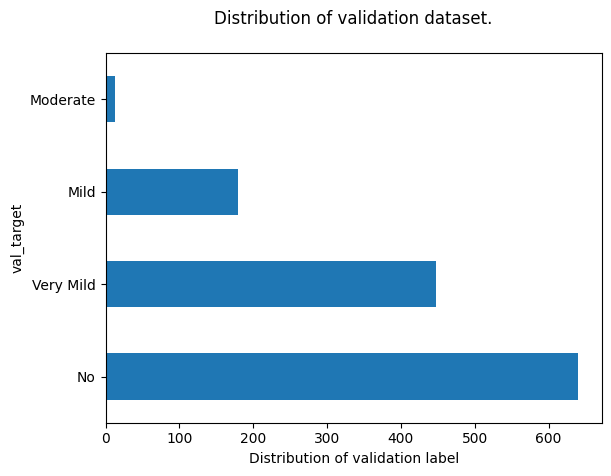

In [8]:
loader.show_distribution()

In [9]:
from alzheimer_classifier.trainer import Trainer

In [10]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [11]:
from alzheimer_classifier.model import classifier

In [12]:
model_classifier = classifier(input_features = 3, output_features = 4)
model_classifier.model_details()

					  Model Details  

		 ________________________________________________________________________________ 

<bound method Module.parameters of classifier(
  (LEFT_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.3, inplace=False)
  )
  (MIDDLE_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding

In [13]:
trainer = Trainer(classifier = model_classifier.to(device), device = device)

In [14]:
import warnings
warnings.filterwarnings('ignore')

trainer.train(train_loader = train_loader, test_loader = test_loader, epochs = 50)

Epochs: 1/50 
[================] m1_loss: 1.3849 - m1_acc: 0.2648 - m2_loss: 1.3842 - m2_acc: 0.2627 - m3_loss: 1.3850 - m3_acc: 0.2550 - val1_loss: 1.3607 - val1_acc: 0.3630 - val2_loss: 1.3484 - val2_acc: 0.3617 - val3_loss: 1.3615 - val3_acc: 0.3180
Epochs: 2/50 
[================] m1_loss: 1.1750 - m1_acc: 0.5550 - m2_loss: 1.1745 - m2_acc: 0.5483 - m3_loss: 1.1928 - m3_acc: 0.5308 - val1_loss: 1.0881 - val1_acc: 0.6387 - val2_loss: 1.0946 - val2_acc: 0.6338 - val3_loss: 1.1090 - val3_acc: 0.6156
Epochs: 3/50 
[================] m1_loss: 1.0791 - m1_acc: 0.6512 - m2_loss: 1.0777 - m2_acc: 0.6551 - m3_loss: 1.0880 - m3_acc: 0.6454 - val1_loss: 1.0209 - val1_acc: 0.7191 - val2_loss: 1.0492 - val2_acc: 0.6833 - val3_loss: 1.0499 - val3_acc: 0.6882
Epochs: 4/50 
[================] m1_loss: 1.0265 - m1_acc: 0.7126 - m2_loss: 1.0287 - m2_acc: 0.7072 - m3_loss: 1.0354 - m3_acc: 0.7009 - val1_loss: 1.0335 - val1_acc: 0.7093 - val2_loss: 1.0249 - val2_acc: 0.7090 - val3_loss: 1.0391 - val3_

AttributeError: ignored

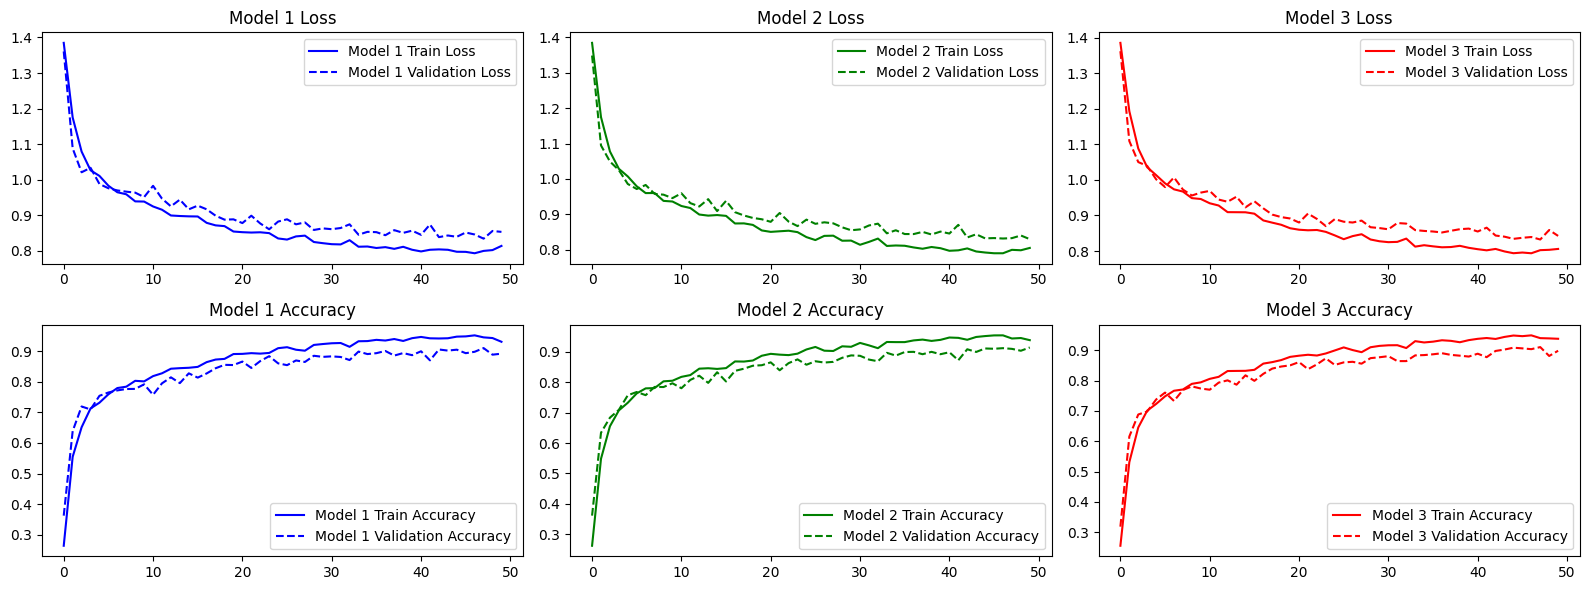

In [15]:
trainer.performance()

In [16]:
model_classifier = trainer.classifier

In [17]:
model_classifier

classifier(
  (LEFT_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.3, inplace=False)
  )
  (MIDDLE_CONV): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(ke

In [18]:
from alzheimer_classifier.metrics import model_performance

Evaluation of Train Dataset with 7168 records. 

ACCURACY  # 0.9559151785714286 
PRECISION # 0.955630542353171 
RECALL    # 0.9583144469726947 
F1_SCORE  # 0.9559981362702653 
__________________________________________________ 

Ëvaluation of Test Dataset  3072 records. 

ACCURACY  # 0.9078776041666666 
PRECISION # 0.9089290225373969 
RECALL    # 0.9142077993592744 
F1_SCORE  # 0.9090635834017791 
__________________________________________________ 

Classification report for test dataset

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       780
           1       1.00      1.00      1.00       754
           2       0.78      0.93      0.85       754
           3       0.90      0.81      0.85       784

    accuracy                           0.91      3072
   macro avg       0.91      0.91      0.91      3072
weighted avg       0.91      0.91      0.91      3072

Confusion matrix for test dataset



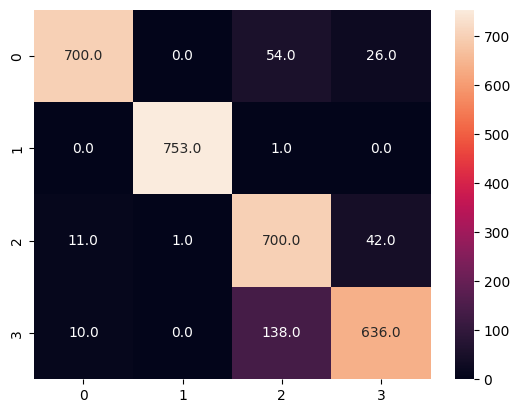

In [19]:
model_performance(model = model_classifier, train_loader=train_loader, test_loader = test_loader, device=device)